# TP04 : Arbres de décision et Forêts aléatoires


## I. Implémentation

Il existe plusieurs implémentations des arbres de décision :
- ID3 (Iterative Dichotomiser 3): dévelopé en 1986 par Ross Quinlan. Il peut être appliqué seulement sur les caractéristiques nominales. Il est utilisé pour le classement.
- C4.5: une extension de ID3 par Ross Quinlan. Il peut être appliqué sur tous les types de caractéristiques. Il est utilisé pour le classement.
- C5.0: une extension commerciale de C4.5, toujours par Ross Quinlan.
- CART (Classification and Regression Trees): comme C4.5 mais utilise d'autres métriques. Aussi, l'algorithme supporte la régression.

Dans ce TP, on va implémenter ID3 pour les caracéristiques nominales et CART (classement) pour les caracéristiques numériques seulement .

### I.1. ID3

Ici, on va implémenter l'algorithme vu dans le cours. On va utiliser le dataset "jouer (nominales)" 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

jouer = pd.read_csv("datasets/jouer.csv")

X_jouer = jouer.iloc[:, :-1].values # Premières colonnes 
Y_jouer = jouer.iloc[:,-1].values # Dernière colonne 

# Afficher le dataset "jouer"
jouer.head()

,temps,temperature,humidite,vent,jouer
0,ensoleile,chaude,haute,non,non
1,ensoleile,chaude,haute,oui,non
2,nuageux,chaude,haute,non,oui
3,pluvieux,douce,haute,non,oui
4,pluvieux,fraiche,normale,non,oui


#### I.1.1. Probabilité 

Etant donné une liste des valeurs $S$, la probabilité d'occurence d'une valeur $v$  est le nombre d'occurence de $v$ dans $S$ divisé par le nombre total des éléments de $S$. 

$$p(v/S) = \frac{|\{x / x \in S \text{ et } x = v\}|}{|S|}$$

Exemple, prenons la colonne "jouer". 
Le nombre de "oui" est 9 et le nombre total est 14. 
$$p(jouer=oui) = \frac{9}{14} = 0.6428571428571429$$

In [2]:
# TODO calculer la probabilité d'occurence d'une valeur val dans un ensemble S
# PS: si la division retourne toujours 0, essayer d'appliquer float(x) sur le numérateur ou le dénominateur
def P(S, v): 
    return np.count_nonzero(S==v)/len(S)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (0.6428571428571429,
#  0.35714285714285715,
#  0.2857142857142857,
#  0.35714285714285715)
#---------------------------------------------------------------------

P(Y_jouer, "oui"), P(X_jouer[:,0], "ensoleile"), P(X_jouer[:, 0], "nuageux"), P(X_jouer[:,0], "pluvieux")

(0.6428571428571429,
 0.35714285714285715,
 0.2857142857142857,
 0.35714285714285715)

#### I.1.2. Incertitude d'un ensemble

L'entropie de Shannon correspond à la quantité d'information contenue dans une source d'information ; plus la source émet d'informations différentes, plus l'entropie (ou l'incertitude sur ce que la source émet) est grande.
Donc, un ensemble avec une entropie de 0 contient les mêmes valeurs.
Etant donné : 
- $S$ une liste des valeurs 
- $V$ un ensemble de valeurs uniques de $S$ (vocabulaire) 

L'entropie de $S$ est calculée comme suit : 
$$H(S) = - \sum\limits_{v \in V} p(v/S) \log_2 p(v/S)$$

Par exemple, la colonne "jouer" contient deux valeurs "oui" et "non". 
Son entopie est :
$$H(jouer) = - \frac{9}{14} * \log_2(\frac{9}{14}) - \frac{5}{14} * \log_2(\frac{5}{14}) = 0.9402859586706309$$ 


In [3]:
# TODO compléter la fonction d'entropie
# np.log2 : calcule log2 d'une valeur, vecteur ou matrice
def H(S):  
    V = np.unique(S)
    entropie = 0
    # Compléter ici
    for carac in V : 
        entropie = entropie - P(S,carac) * np.log2(P(S,carac))
    return entropie 

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.9402859586706311, 1.5774062828523454)
#---------------------------------------------------------------------

H(Y_jouer), H(X_jouer[:,0])

(0.9402859586706311, 1.5774062828523454)

#### I.1.3. Division d'un ensemble

**Rien à programmer ici**

Ici, on essaye de diviser la liste des prédictions (classes) selon les valeurs d'un attribut (caractéristique, colonne) à des sous listes. 

Etant donné : 
- **Y** : la liste à diviser
- **A** : la liste des valeurs d'un attribut (caractéristique, colonne). C'est un vecteur aligné avec Y ; c-à-d, chaque élément de A a un élément de Y respectif.
- **v** : la valeur sur laquelle on divie.

$$S_{A,v} = \{y^{(i)} \in Y / a^{(i)} \in A \wedge a^{(i)} = v\}\}$$

Par exemple, si 
- $Y$ est la liste des prédictions de "jouer"
- $A$ est la liste des valeurs de la caractéristique "temps"
- $v$ est la valeur "ensoleile"
La sous ensemble de "jouer" où (temps = "ensoleile") contient 3 non et 2 oui 

In [4]:
def diviser_ID3(Y, A, v):
    msk = A == v
    return Y[msk]

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : array(['non', 'non', 'non', 'oui', 'oui'], dtype=object)
#---------------------------------------------------------------------

diviser_ID3(Y_jouer, X_jouer[:,0], "ensoleile")

array(['non', 'non', 'non', 'oui', 'oui'], dtype=object)

#### I.1.4. Gain d'entropie

Le gain d'entropie (information gain) est la différence entre l'entropie avant et après la division d'une liste $Y$ selon l'attribut $A$. 
En d'autres termes, combien d'incertitude dans $Y$ a été réduite après sa division en utilisant l'attribut $A$.

Etant donné : 
- **Y** : une liste à diviser
- **A** : une liste des valeurs d'un attribut (caractéristique, colonne) 
- **V** : l'ensemble des valeurs différentes de l'attribut A (vocabulaire)
- **p(v/A)** : la probabité d'occurence de la valeur $v$ dans $A$
- $Y_{A, v}$ : sous-ensemble de $Y$ où les valeurs de $V$ égalent à $v$  en utilisant la fonction précédente (diviser_ID3)

Le gain d'entrepie se calcule comme suit : 

$$IG(Y, A) = H(Y) - \sum_{v \in V} p(v/A) H(Y_{A, v})$$

In [5]:
# TODO Compléter la fonction du gain d'entropie
# elle doit rendre le gain d'entropie et l'entropie 
# On rend l'entropie pour ne pas recalculer ultérierement 
def IG(Y, A):
    V = np.unique(A)
    entropie = H(Y)
    ig_global = entropie
    # Compléter ici
    for carac in V : 
        ig_global= ig_global - P(A,carac) * H(diviser_ID3(Y,A,carac))
    return ig_global, entropie

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

IG(Y_jouer, X_jouer[:, 0])

(0.24674981977443933, 0.9402859586706311)

#### I.1.5. Choix de l'attribut de division ID3

Ici, vous devez chercher l'attribut qui maximise IG.

$$jj = \arg\max_j IG(Y, X_j)$$

La fonction doit rendre jj, le IG de division en utilisant jj et l'entropy

In [6]:
# TODO compléter la fonction du choix d'attribut de dévision
# le plus adéquat pour diviser Y 
# elle doit, aussi, rendre le IG et le H de ce caractéristique 
def choisir_devision_ID3(X, Y): 
    jj = -1 # numéro d'attribut qui maximise IG
    ig_jj = -1.0 # IG de cet attribut (le max)
    h_jj = -1.0  # Entropie 
    # Compléter ici
    igTAB=np.zeros(X.shape[1])
    for i in range (X.shape[1]):
        igTAB[i],h_jj=IG(Y,(X.T)[i])
    jj=np.argmax(igTAB)
    ig_jj=igTAB[jj]
    return jj, ig_jj, h_jj

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0, 0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

choisir_devision_ID3(X_jouer, Y_jouer)

(0, 0.24674981977443933, 0.9402859586706311)

#### I.1.6. Arrêt de division

Etant donné les données suivantes :
- **Y** : l'ensemble des prédiction au niveau d'un noeud
- **h** : le critère d'homoginiété. h = 0 ==> l'ensemble Y est homogène (mêmes valeurs)
- **nbr_min** : le nombre minimale des observations dans un noeud. |Y| <= nbr_min ==> le noeud doit être une feuille

La fonction d'arrêt doit retourner : 
- Le nom de la classe : si l'ensemble est homogène ou il contient un nombre minimal des éléments
- None : sinon

In [7]:
# TODO : réaliser la fonction d'arrêt ID3
# HINT : utiliser numpy.unique et numpy.argmax
def arreter_ID3(Y, h, nbr_min):
    if (h==0) or (len(Y) <= nbr_min) :
        unique, counts = np.unique(Y, return_counts=True)
        d = dict(zip(unique, counts))
        return max(d, key = d.get)
    else : 
        return None

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : ('oui', 'non', None)
#---------------------------------------------------------------------

Y_t1 = np.array(["oui", "oui", "oui"])
Y_t2 = np.array(["oui", "non", "non"])
arreter_ID3(Y_t1, H(Y_t1), 2), arreter_ID3(Y_t2, H(Y_t2), 4), arreter_ID3(Y_t2, H(Y_t2), 2)

('oui', 'non', None)

#### I.1.7. Création de l'arbre

**Rien à programmer ici**


In [8]:
# Une classe pour contenir les informations du noeud et 
# la liste de ces fils
class Noeud(object): 
    
    nbr = 0
    
    def __init__(self, num, ig, h, profondeur): 
        self.num = num # le numéro du caractéristique de dévision dans X
        self.ig = ig # le IG de division
        self.h = h # l'entropie H
        self.pr = profondeur # la profondeur du noeud
        self.fils = {} # les fils ; un dictionnaire valeur : noeud
        self.cls = "" # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent = "    " # indentation lorsqu'on génère le code
    
    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre 
    #sous form d'un algorithme ; c'est un parser 
    def __str__(self):
        
        indent = self.indent * self.pr # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.fils)==0):
            return indent + 'Y est "' + self.cls + '"\n'
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        res = ""
        for valeur in self.fils:
            res += indent + 'Si X[' + str(self.num) + '] est "' + str(valeur) + '" Alors\n' + str(self.fils[valeur])
        return res
    
    # predire un échantillon
    def predire(self, x): 
        
        # Si le noeud est final, il rend sa classe 
        if (len(self.fils)==0):
            return self.cls
        
        # Si la valeur de la colonne respective à ce noeud n'appartient pas à l'ensemble des
        # valeurs attendues, on rend np.nan
        if x[self.num] not in self.fils: 
            return np.nan
        
        # Sinon, on rend 
        return self.fils[x[self.num]].predire(x)
    
    # générer un code pour graphviz
    def graphviz(self): 
        
        nid = 'N' + str(Noeud.nbr)
        Noeud.nbr += 1
        
        # Si le noeud est final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        # Sinon, 
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        res = nid + '[label="X[' + str(self.num) + ']\\n'
        res += 'H = ' + str(self.h) + '\\n'
        res += 'IG = ' + str(self.ig) + '"];\n'
        for valeur in self.fils:
            vid, code = self.fils[valeur].graphviz()
            res += code
            res += nid + ' -> ' + vid + ' [label="' + valeur + '"];\n'
        return nid, res
    

# créer l'arbre de décision à partir d'un ensemble X et Y
def entrainer_ID3(X, Y, nbr_min=0, profondeur=0): 
    
    # Chercher la meilleure caractéristique de X pour diviser Y
    jj, ig_jj, h_jj = choisir_devision_ID3(X, Y)
    # Créer un noeud
    noeud = Noeud(jj, ig_jj, h_jj, profondeur)
    # si arrêter rend une classe, donc c'est une feuille 
    cls = arreter_ID3(Y, h_jj, nbr_min)
    if cls:
        noeud.cls = cls # la classe du noeud
        return noeud # retourner le noeud 
    
    # Sinon, si le noeud n'est pas une feuille, on crée ces fils
    profondeur += 1 # la profondeur de ces fils
    # les fils sont créés à partir des valeurs uniques du meilleur caractéristique
    for v in np.unique(X[:, jj]):
        # Ces trois lignes sont pour récupérer les sous-ensembles X_val, Y_val
        # Corresondants à une valeur du meilleur caractéristique
        msk = X[:, jj] == v 
        X_v = X[msk]
        Y_v = Y[msk]
        # On refait la même opération sur l'ensemble (Y_val) d'une manière récursive
        fils = entrainer_ID3(X_v, Y_v, nbr_min=nbr_min, profondeur=profondeur)
        # On affecte le noeud créé indexé par la valeur du meilleur caractéristique 
        # à l'ensemble des fils du noeud courant
        noeud.fils[v] = fils
    
    return noeud

arbre_jouer = entrainer_ID3(X_jouer, Y_jouer)

print("Le Code")
print(arbre_jouer)

# Tester sur un échantillon
arbre_jouer.predire(["pluvieux", "temperature_makanche", "humidite_makanche", "non"])

Le Code
Si X[0] est "ensoleile" Alors
    Si X[2] est "haute" Alors
        Y est "non"
    Si X[2] est "normale" Alors
        Y est "oui"
Si X[0] est "nuageux" Alors
    Y est "oui"
Si X[0] est "pluvieux" Alors
    Si X[3] est "non" Alors
        Y est "oui"
    Si X[3] est "oui" Alors
        Y est "non"



'oui'

#### I.1.8. Regrouper le tous

**Rien à programmer ici**

In [9]:
class ID3(object): 
    
    def entrainer(self, X, Y, X_noms=[], Y_nom="", nbr_min=0):
        self.arbre = entrainer_ID3(X, Y, nbr_min=nbr_min)
        code = str(self.arbre)
        if len(Y_nom) > 0: 
            code = code.replace("Y", Y_nom)
        for i in range(len(X_noms)): 
            code = code.replace("X[" + str(i) + "]", X_noms[i])
        self.code = code
        self.X_noms = X_noms
    
    def predire(self, X): 
        predictions = []
        for i in range(len(X)): 
            predictions.append(self.arbre.predire(X[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.arbre.graphviz()
        res = "digraph Tree {\n"
        res += "node [shape=box] ;"
        for i in range(len(self.X_noms)): 
            code = code.replace("X[" + str(i) + "]", self.X_noms[i])
        res += code
        res += "}"
        return res

id3_classifieur = ID3()
id3_classifieur.entrainer(X_jouer, Y_jouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")
print(id3_classifieur.code)

Si temps est "ensoleile" Alors
    Si humidite est "haute" Alors
        jouer est "non"
    Si humidite est "normale" Alors
        jouer est "oui"
Si temps est "nuageux" Alors
    jouer est "oui"
Si temps est "pluvieux" Alors
    Si vent est "non" Alors
        jouer est "oui"
    Si vent est "oui" Alors
        jouer est "non"



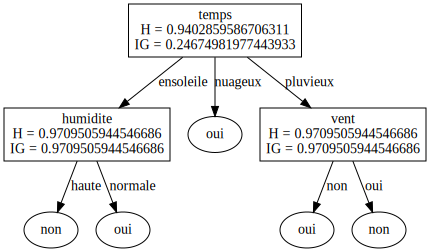

In [10]:
# C'est juste une visualisation du graphe
# Si ça ne marche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph = Source(id3_classifieur.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

### I.2. CART

Ici, on va implémenter l'algorithme CART pour la classification avec des caractéristiques numériques. On va utiliser le dataset "jouer (numériques)". 


In [11]:
njouer_data = pd.read_csv("datasets/jouer_num.csv")
X_njouer = njouer_data.iloc[:, :-1].values # Premières colonnes 
Y_njouer = njouer_data.iloc[:,-1].values # Dernière colonne 
njouer_data.head()

,temperature,humidite,vent,jouer
0,30,85,0,non
1,27,90,1,non
2,28,78,0,oui
3,21,96,0,oui
4,20,80,0,oui


#### I.2.1. Index de diversité de Gini

Dans le cas de classement, CART utilise l'indexe de diversité Gini pour mesurer l'erreur de classification.
Un index de 0 représente la meilleure division; 

Etant donné : 
- $S$ liste des valeurs  
- $V$ ensemble des valeurs uniques de $S$  (vocabulaire)

L'index de diversité  $Gini(S)$ est calculée comme suit : 
$$Gini(S) = \sum\limits_{v \in V} p(v/S) (1-p(v/S)) = 1 - \sum\limits_{v \in V} p(v/S)^2 $$

In [12]:
# TODO compléter la fonction Gini
def Gini(S):  
    V = np.unique(S)
    gini = 1
    # Compléter ici
    for carac in V :
        gini = gini - (P(S,carac))**2
    return gini 

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 0.4591836734693877
#---------------------------------------------------------------------

Gini(Y_njouer)

0.4591836734693877

#### I.2.2. Division d'un ensemble

**Rien à programmer ici**

Ici, on essaye de diviser la liste des prédictions (classes) $Y$ selon une valeur donnée $v$ d'un attribut (caractéristique, colonne) $A$ sur deux listes :
- $Y_G$ : une liste contenant les éléments de $Y$ où $A > v$
- $Y_D$ : une liste contenant les éléments de $Y$ où $A \le v$


In [13]:
def diviser_CART(Y, A, v):
    msk = A > v
    return Y[msk], Y[~msk]

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array(['non', 'non', 'oui', 'oui', 'non', 'oui', 'oui', 'oui', 'oui',
#         'oui', 'non'], dtype=object),
#  array(['oui', 'non', 'oui'], dtype=object))
#---------------------------------------------------------------------

diviser_CART(Y_njouer, X_njouer[:,0], 20)

(array(['non', 'non', 'oui', 'oui', 'non', 'oui', 'oui', 'oui', 'oui',
        'oui', 'non'], dtype=object),
 array(['oui', 'non', 'oui'], dtype=object))

#### I.2.3. Diversité Gini de la division

Etant donné : 
- **Y** : une liste des prédictions
- **V** : les différentes valeurs de Y (les classes
- S_G, G_D : sous ensembles gauche et droit
- $|S| = |S_G| + |S_D|$

La diversité Gini de la division : 

$$Gini_{div}(S_G, S_D) = \frac{|S_G|}{|S|} Gini(S_G) + \frac{|S_D|}{|S|} Gini(S_D)$$


In [14]:
# TODO compléter la fonction diversité gini de la division
def Gini_div(S_G, S_D): 
    S_len = float(len(S_G) + len(S_D)) 
    # Compléter ici
    return len(S_G)/S_len*Gini(S_G) + len(S_D)/S_len*Gini(S_D)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 0.4588744588744589
#---------------------------------------------------------------------

S_G, S_D = diviser_CART(Y_njouer, X_njouer[:, 0], 20)
Gini_div(S_G, S_D)

0.4588744588744589

#### I.2.4. Choix de l'attribut et la valeur de division CART

L'algorithme
- Pour chaque ccaractéristique $X_j$ 
   - Pour chaque valeur $v$ appartennant aux valeurs uniques de $X_j$
       1. Diviser $Y$ en se basant sur la valeur $v$ et celles de $X_j$
       1. Calculer Gini de cette division 
       1. Garder l'indice **jj** de la caractéristique qui minimise Gini
       1. Garder Gini minimale **gini_jj**
       1. Garder la valeur de dévision **v_jj**
       

In [15]:
# TODO compléter la fonction du choix de l'attribut et la valeur de division CART
def choisir_division_CART(X, Y): 
    jj = -1
    gini_jj = 1.0
    v_jj = -1.0
    # Compléter ici
    giniTABG=dict()
    for i in range (X.shape[1]):
        V=np.unique((X.T)[i])
        giniTAB=dict()
        L=list()
        for V_carac in V :
            S_G, S_D = diviser_CART(Y,(X.T)[i],V_carac)
            giniTAB[V_carac] = Gini_div(S_G, S_D)
        L.append(min(giniTAB, key = giniTAB.get))
        L.append(giniTAB.get(L[0]))
        giniTABG[i]= L
    L2=list()
    for (k, val) in giniTABG.items() : 
        L2.append(val[1])
    jj=np.argmin(L2)
    v_jj=(giniTABG.get(jj))[0]
    gini_jj=(giniTABG.get(jj))[1]
    return jj, gini_jj, v_jj

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (1, 0.3936507936507937, 80)
#---------------------------------------------------------------------

choisir_division_CART(X_njouer, Y_njouer)

(1, 0.3936507936507937, 80)

#### I.2.5. Arrêt de division CART

**Rien à programmer ici** 

On va utiliser la même fonction que celle de ID3. Mais, pour être consistant, on va seulement renomer la fonction et passer Gini à la place de l'entropie.

In [16]:
arreter_CART = arreter_ID3

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : ('oui', 'non', None)
#---------------------------------------------------------------------

Y_t1 = np.array(["oui", "oui", "oui"])
Y_t2 = np.array(["oui", "non", "non"])
arreter_CART(Y_t1, H(Y_t1), 2), arreter_CART(Y_t2, H(Y_t2), 4), arreter_CART(Y_t2, H(Y_t2), 2)

('oui', 'non', None)

#### I.2.6. Création de l'arbre

**Rien à programmer ici**

In [17]:
# Comme Noeud, mais il faut changer un peu, puisqu'on teste sur des 
# valeurs numériques aussi
# Le code sera plus utilisable si on crée une classe commune et on hérite
# Mais, je n'ai pas le temps pour tout ça (DEAL WITH IT)
class NoeudBin(object): 
    
    nbr = 0
    
    def __init__(self, num, val, gini, profondeur): 
        self.num = num # le numéro du caractéristique de dévision dans X
        self.val = val
        self.gini = gini # le Gini de division
        self.pr = profondeur # la profondeur du noeud
        self.fils = [] # les fils ; un tableau de deux noeuds: S_G, S_D
        self.cls = "" # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent = "    " # indentation lorsqu'on génère le code
    
    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre 
    #sous form d'un algorithme ; c'est un parser 
    def __str__(self):
        
        indent = self.indent * self.pr # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.fils)==0):
            return indent + 'Y est "' + self.cls + '"\n'
         
        prefix = ' > '
        suffix = ''
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS SINON
        res = ""
        res += indent + 'Si X[' + str(self.num) + '] ' + prefix + str(self.val) + suffix + ' Alors\n' + str(self.fils[0])
        res += indent + 'Sinon\n' + str(self.fils[1])
        return res
    
    # predire un échantillon
    def predire(self, x): 
        
        # Si le noeud est final, il rend sa classe 
        if (len(self.fils)==0):
            return self.cls
        
        # sinon
        if x[self.num] > self.val:
            return self.fils[0].predire(x)
        return self.fils[1].predire(x)

    
    # générer un code pour graphviz
    def graphviz(self): 
        
        nid = 'N' + str(NoeudBin.nbr)
        NoeudBin.nbr += 1
        
        # Si le noeud est final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        # Sinon, 
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        prefix = '] > '
        res = nid + '[label="X[' + str(self.num) + prefix + str(self.val) + '\\n'
        res += 'Gini = ' + str(self.gini) + '"];\n'
        vid_G, code_G = self.fils[0].graphviz()
        vid_D, code_D = self.fils[1].graphviz()
        
        res += code_G + code_D
        res += nid + ' -> ' + vid_G + ' [label="Vrai"];\n'
        res += nid + ' -> ' + vid_D + ' [label="Faux"];\n'
        return nid, res

# créer l'arbre de décision à partir d'un ensemble X et Y
def entrainer_CART(X, Y, profondeur=0, nbr_min=0): 
    
    # Chercher le meilleur caractéristique de X pour diviser Y
    jj, gini_jj, v_jj = choisir_division_CART(X, Y)
    # Créer un noeud
    noeud = NoeudBin(jj, v_jj, gini_jj, profondeur)
    # Si l'entropie est 0 donc le noeud est terminal, élagage
    
    cls = arreter_CART(Y, gini_jj, nbr_min)
    if cls:
        noeud.cls = cls # la classe du noeud
        return noeud # retourner le noeud 
     
    
    # Sinon, si le noeud n'est pas terminal, on crée ces fils
    profondeur += 1 # la profondeur de ces fils
    # création des deux fils
    
    msk = X[:, jj] > v_jj
    
    X_G = X[msk]
    Y_G = Y[msk]
    fils_G = entrainer_CART(X_G, Y_G, profondeur, nbr_min)
    X_D = X[~msk]
    Y_D = Y[~msk]
    fils_D = entrainer_CART(X_D, Y_D, profondeur, nbr_min)
    noeud.fils.append(fils_G)
    noeud.fils.append(fils_D)
    
    return noeud

arbre_njouer = entrainer_CART(X_njouer, Y_njouer)

print("Le Code")
print(arbre_njouer)

Le Code
Si X[1]  > 80 Alors
    Si X[0]  > 22 Alors
        Y est "non"
    Sinon
        Si X[0]  > 21 Alors
            Y est "non"
        Sinon
            Y est "oui"
Sinon
    Si X[2]  > 0 Alors
        Si X[1]  > 70 Alors
            Y est "non"
        Sinon
            Si X[0]  > 18 Alors
                Y est "oui"
            Sinon
                Y est "non"
    Sinon
        Y est "oui"



#### I.2.7. Regrouper le tous

**Rien à programmer ici**

In [18]:
class CART(object): 
    
    def entrainer(self, X, Y, X_noms=[], Y_nom="", nbr_min=0):
        self.arbre = entrainer_CART(X, Y, 0, nbr_min)
        code = str(self.arbre)
        if len(Y_nom) > 0: 
            code = code.replace("Y", Y_nom)
        for i in range(len(X_noms)): 
            code = code.replace("X[" + str(i) + "]", X_noms[i])
        self.code = code
        self.X_noms = X_noms
    
    def predire(self, X): 
        predictions = []
        for i in range(len(X)): 
            predictions.append(self.arbre.predire(X[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.arbre.graphviz()
        res = "digraph Tree {\n"
        res += "node [shape=box] ;"
        for i in range(len(self.X_noms)): 
            code = code.replace("X[" + str(i) + "]", self.X_noms[i])
        res += code
        res += "}"
        return res

cart_classifieur = CART()
cart_classifieur.entrainer(X_njouer, Y_njouer, X_noms=["temperature", "humidite", "vent"], Y_nom="jouer")
print(cart_classifieur.code)

Si humidite  > 80 Alors
    Si temperature  > 22 Alors
        jouer est "non"
    Sinon
        Si temperature  > 21 Alors
            jouer est "non"
        Sinon
            jouer est "oui"
Sinon
    Si vent  > 0 Alors
        Si humidite  > 70 Alors
            jouer est "non"
        Sinon
            Si temperature  > 18 Alors
                jouer est "oui"
            Sinon
                jouer est "non"
    Sinon
        jouer est "oui"



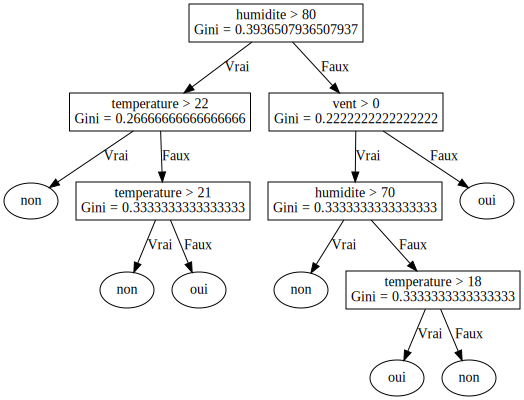

In [19]:
# C'est juste une visualisation du graphe
# Si ça ne marche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph = Source(cart_classifieur.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

## II. Application et analyse

On va utiliser le dataset [Cars Data](https://www.kaggle.com/abineshkumark/carsdata) pour classer les voitures en trois classes : US., Euroupe. ou Japan. 

In [20]:
# Lecture du dataset
cars_data = pd.read_csv('datasets/cars.csv', skipinitialspace=True)
# On a remarqué que le type de cette caractéristique n'est pas bien détecté
cars_data["cubicinches"] = pd.to_numeric(cars_data["cubicinches"])
# supprimer les valeurs absentes 
cars_data.dropna(inplace=True)
# Yay! We did it! Voici les premières lignes du dataset
cars_data.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350.0,165,4209.0,12,1972,US.
1,31.9,4,89.0,71,1925.0,14,1980,Europe.
2,17.0,8,302.0,140,3449.0,11,1971,US.
3,15.0,8,400.0,150,3761.0,10,1971,US.
4,30.5,4,98.0,63,2051.0,17,1978,US.


In [21]:
from sklearn.model_selection import train_test_split

X_cars = cars_data.values[:, :-1]
Y_cars = cars_data.values[:,-1]

X_cars_train, X_cars_test, Y_cars_train, Y_cars_test = train_test_split(X_cars, Y_cars, test_size=0.2, random_state=0) 

X_cars_train.shape, X_cars_test.shape

((204, 7), (52, 7))

### II.1. Arbres de décision

Dans l'implémentation Scikit-learn des arbres de décision (**DecisionTreeClassifier**), les caractéristiques sont permutées d'une façon aléatoire à chaque division. Ceci rendre l'arbre non déterministe. Pour arrêter ça, on utilise la proporiété **random_state=0**

#### II.1.1. Critère de choix des caractéristiques

Nous avons entraîné deux arbres de décision CART avec les critères de division : 
- Entropy
- Gini

**TODO : Analyser les résultats**
- Que remarquez-vous concernant la structure des deux arbres : ENTOPY (à gauche) et GINI (à droit) ? La structure veut dire : la profendeur et le nombre des feuilles.
- Justifier le temps d'entraînement et de test en se basant sur les deux algorithmes et les deux structures discutées.

**Réponse**
- On remarque que les deux arbres de décisions obtenues avec les critéres de division Entropy et Gini sont différents, on voit bien que les deux arbres n'ont pas la meme profondeur, l'arbre obtenu avec l'entropy a une profondeur de 14 tandis que celui obtenu avec gini a une profondeur egale a 16, par contre ils ont le meme nombre de feuilles.On voit également que les noeuds sont répartis de maniére différentes (la séparation qui est éffectuée au niveau de chaque noeud est différente)
- Le temps d'entrainement est légérement plus élevée pour l'arbre avec gini que celui avec entropy, on peut expliquer ça par le fait que l'arbre construit avec gini est plus profond que celui construit avec entropy par concéquent sa construction est un peu moins rapide. On remarque également que les résultats de prédiction (sur les données de test) obtenus avec l'entropy sont légérement meilleurs que ceux obtenus avec l'arbre gini. Pour ce qui est du temp de test il est un peu moins rapide pour gini car la phase de test représente un parcours de l'arbre de la racine jusqu'a une feuille et l'arbre de gini est plus profond que l'arbre avec entropy donc le temps de parcours est plus long.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import timeit
from sklearn import tree

Xchoix_train = X_cars_train
Ychoix_train = Y_cars_train
Xchoix_test = X_cars_test
Ychoix_test = Y_cars_test
fnames = cars_data.columns

#Xchoix_train = X_njouer[4:, :]
#Ychoix_train = Y_njouer[4:]
#Xchoix_test = X_njouer[:4, :]
#Ychoix_test = Y_njouer[:4]
#fnames = ["temperature", "humidite", "vent"]


gini_stats = []
entropy_stats = []
gini_classifieur = DecisionTreeClassifier(criterion="gini", random_state=0)
entropy_classifieur = DecisionTreeClassifier(criterion="entropy", random_state=0)

# ============ GINI ====================
# ............ Entraînement ............
temps_debut = timeit.default_timer()
gini_classifieur.fit(Xchoix_train, Ychoix_train)
gini_stats.append(timeit.default_timer() - temps_debut)
# ..... Evaluation entrainement ........
gini_stats.append(f1_score(Ychoix_train, gini_classifieur.predict(Xchoix_train), average="micro"))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = gini_classifieur.predict(Xchoix_test)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
gini_stats.append(f1_score(Ychoix_test, Ychoix_pred, average="micro"))

# =========== Entropy ==================
# ............ Entraînement ............
temps_debut = timeit.default_timer()
entropy_classifieur.fit(Xchoix_train, Ychoix_train)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ..... Evaluation entrainement ........
entropy_stats.append(f1_score(Ychoix_train, entropy_classifieur.predict(Xchoix_train), average="micro"))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = entropy_classifieur.predict(Xchoix_test)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
entropy_stats.append(f1_score(Ychoix_test, Ychoix_pred, average="micro"))

print("Fini")

Fini


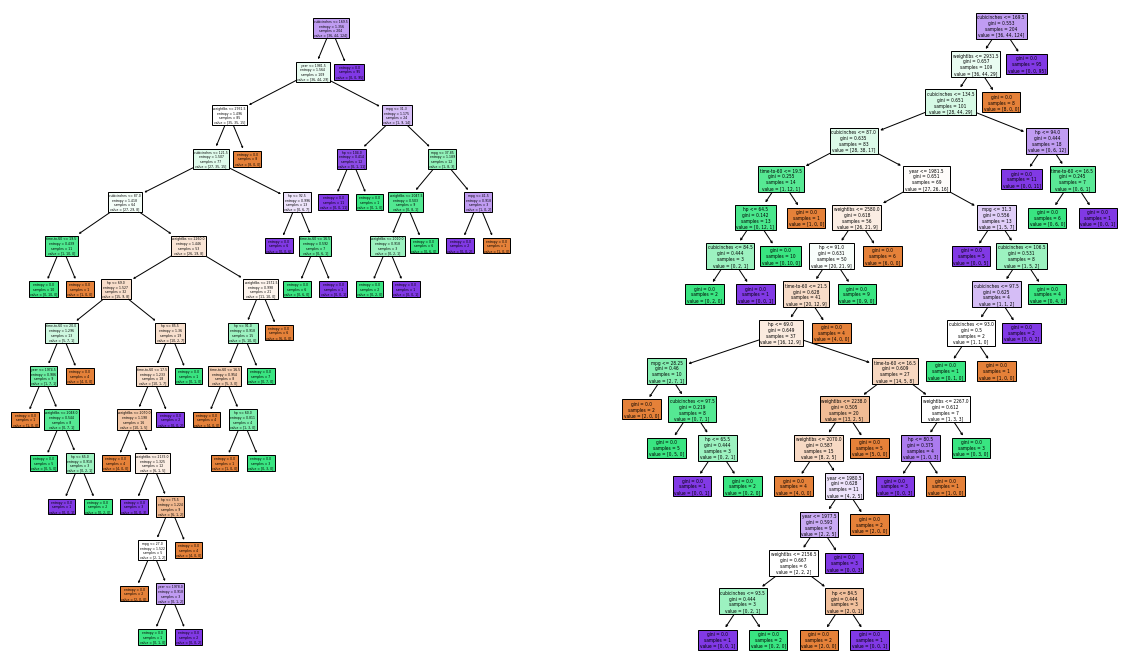

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(12)
tree.plot_tree(entropy_classifieur, ax=ax1, feature_names=fnames, filled=True)
tree.plot_tree(gini_classifieur, ax=ax2, feature_names=fnames, filled=True)
plt.show()

In [24]:
pd.DataFrame({
    "Criteres" : ["Temps Entrainement", "F1 Entrainement", "Temps Test", "F1 Test"],
    "Entropie" : entropy_stats,
    "Gini" : gini_stats
})

,Criteres,Entropie,Gini
0,Temps Entrainement,0.001578,0.001674
1,F1 Entrainement,1.000000,1.000000
2,Temps Test,0.000214,0.000342
3,F1 Test,0.826923,0.788462


#### II.1.2. Profondeur maximale de l'arbre

Pour chaque profondeur, on entraîne un modèle et on mesure sa convergence et sa performance en terme du score F1. 

**TODO : Analyser les résultats**
- Que remarquez-vous ? (Est-ce que plus de profondeur veut dire le modèle va généraliser mieux)
- Justifier

**Réponse**
- On remarque qu'un plus grande profondeur n'implique pas forcément un meilleur modéle (qui va généraliser mieux) car on remarque qu'apres une profondeur égale a environ 17 la qualité de prédiction sur les données de test stagne (le f1 score n'augmente plus malgrés l'augmentation de la profondeur).
- Justification : Lorsque la valeur de la profondeur max etait < a 17 on voit que le f1 score au niveau de l'entrainement etait inférieur a 1 cela signifie que le modéle obtenue pour une tel profondeur ne posséde pas de feuilles parfaitement homogéne donc l'algorithme construction s'est arréte car la profondeur max defini a été atteinte. Ceci a engendré une moins de moins bonnes prédictions au niveau des tests. Pour une  profondeur max > 17 la valeure du f1 score est = 1 au niveau de l'entraînement cela veut dire que le modèle obtenue  posséde des feuilles parfaitement homogène donc l'algorithme s'arrete et on obtient un arbre de profondeur < a 17. Donc le fait de faire varier la valeur de la profondeur max après 17 ne va plus influencer le modèle qu'on obtient (ça sera toujours le même modèle)  et c'est pour cela que le f1 score reste égale à 0.78 environ vu que finalement on fait les tests sur le même modèle quelque soit la valeure de la profondeur max > a 17.

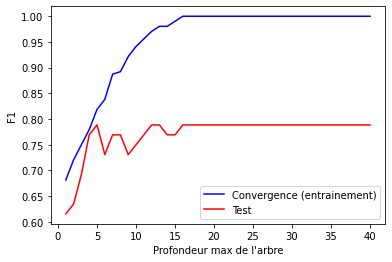

In [25]:
MAX_PROF = 40

MAX_PROF_lst = range(1, MAX_PROF+1, 1)

f1_train_pm = []
f1_test_pm = []
for max_prof in MAX_PROF_lst:
    classifieur = DecisionTreeClassifier(random_state=0, max_depth=max_prof)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_pm.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_pm.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(MAX_PROF_lst, f1_train_pm, color="blue", label="Convergence (entrainement)")
plt.plot(MAX_PROF_lst, f1_test_pm, color="red", label="Test")
plt.ylabel("F1")
plt.xlabel("Profondeur max de l'arbre")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

#### II.1.3. Observations minimales dans les feuilles

Pour chaque nombre des observations minimales dans les feuilles, on entraîne un modèle et on mesure sa convergence et sa performance en terme du score F1. 

**TODO : Analyser les résultats**
- Que remarquez-vous ?
- Justifier pourquoi la performance se diminue (en indiquant si ce critère d'arrêt garantie un apprentissage normale ou peut causer un sur-apprentissage ou sous-apprentissage)

**Réponse**
- On remarque que plus la valeur du nombre d'observations minimales dans les feuilles augmente plus la qualité de la prédiction (f1 score) sur les données d'entrainement diminue, concernant les données de test on remarque que entre une valeure minimale entre 0 et 10 on a la meilleure qualité de prédiction (meilleure valeur du f1 score) par ailleurs lorque la valeure minimale augmente au dessus de 10 le f1 score varie de maniere non stable et quasi aléatoire.
- Justification : au niveau de l'entrainement plus la valeur du nombre d'observations minimales dans les feuilles augmente moins on étudira tous les attributs de notre dataset car une fois cette valeure minimal atteinte le noeud ne sera plus diviser et il devient alors une feuille meme si cette derniere n'est pas homogéne, donc le mdodéle construit sur les données d'entrainemant ne posséde pas de feuilles pures (F1 score < 1) ceci entraine donc un probleme de sous-apprentissage et affecte alors la qualité de notre modéle et donc la qualité des predictions sur les données de test. De maniere général une valeur minimal trop grande cause un probléme de sous-apprentissage comme dans ce cas la, et une valeure minimal trop petite peut causer un probleme de sur-apprentissage si on a pas définit un autre critére d'arret (profondeur max) car on chercherait a beaucoup trop diviser les individus pour avoir des feuilles pures (l'arbre risque d'avoir autant de feuilles qu'il y a d'individus dans la population).

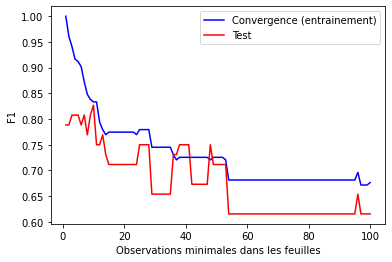

In [35]:
MIN_FEUILLE = 100

MIN_FEUILLE_lst = range(1, MIN_FEUILLE+1, 1)

f1_train_mf = []
f1_test_mf = []
for min_feuille in MIN_FEUILLE_lst:
    classifieur = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_feuille)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_mf.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_mf.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(MIN_FEUILLE_lst, f1_train_mf, color="blue", label="Convergence (entrainement)")
plt.plot(MIN_FEUILLE_lst, f1_test_mf, color="red", label="Test")
plt.ylabel("F1")
plt.xlabel("Observations minimales dans les feuilles")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

### II.2. Forêts aléatoires

#### II.2.1. Nombre des arbres

Pour chaque nombre des arbres dans le forêt, on entraîne un modèle et on mesure sa convergence et sa performance en terme du score F1. 

**TODO : Analyser les résultats**
- Que remarquez-vous ? (convergence et généralisation)

**Réponse**
- On remarque que pour un nombre d'arbre inférieur a 40 la valeur du f1 score de la convergence (entrainement) n'est pas totalement stable sur 1 ce qui signifie que la majorité des arbres obtenues dans notre foret ne possédent pas tous des feuilles homogénes, ce qui fait que la qualité de prediction sur les données de test varie dans un intervalle trop grand (entre 0.75 et 0.92) donc on a un modele qui n'est pas stable et qui ne généralise pas bien. Par contre au bout de 40 arbres le f1 score de la convergence (enrainement) est stable sur 1 ce qui signifie que la majorité des arbres obtenues de notre forets possédent tous des feuilles homogénes et on remarque de meilleurs résultats de prédiction sur les données de test avec une variation du f1 score dans un intervalle plus petit (entre 0.83 et 0.92) on a donc un modéle qui généralise assez bien.

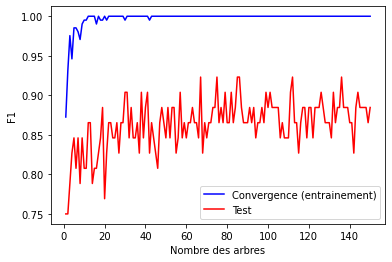

In [27]:
from sklearn.ensemble import RandomForestClassifier

MAX_ARBRE = 150

MAX_ARBRE_lst = range(1, MAX_ARBRE+1, 1)

f1_train_nbarbres = []
f1_test_nbarbres = []
for max_arbres in MAX_ARBRE_lst:
    classifieur = RandomForestClassifier(n_estimators=max_arbres)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_nbarbres.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_nbarbres.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(MAX_ARBRE_lst, f1_train_nbarbres, color="blue", label="Convergence (entrainement)")
plt.plot(MAX_ARBRE_lst, f1_test_nbarbres, color="red", label="Test")
plt.ylabel("F1")
plt.xlabel("Nombre des arbres")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

#### II.2.2. Profondeur maximale des arbres

Pour chaque profondeur, on entraîne un forêt et on mesure sa convergence et sa performance en terme du score F1. On compare les résultats avec les arbres équivalents (avec la même profondeur)

**TODO : Analyser les résultats**
- Comparer la convergence des forêts et des arbres en terme de la profondeur maximale
- Comparer la généralisation des forêts et des arbres en terme de la profondeur maximale
- Justifier ces résultats (en indiquant pourquoi nous avons des oscillations dans F1 test des forêts)

**Réponse**
- On remarque que la convergence des forets aléatoires est plus rapide que celle de l'arbre de décision en effet on remarque que les forets aléatoires ont un f1 score qui approxime 1 aux environs d'une profondeur max egale a 8 environ tandis que l'arbre ne converge qu'au bout d'une profondeur egale a 16 environ, par ailleurs on remarque qu'une fois que l'arbre a atteind un f1 score egale 1 il stagne de maniére stable sur cette valeure contrairement a la foret aléatoire qui tourne autour de la valeure 1 avec des petits bruits.
- On remarque que la généralisation du modéle foret aléatoire est bien meilleur (atteind jusqu'a 0.90 de valeur de f1 score) que celle avec l'arbre aléatoire qui ne dépasse pas 0.78 comme valeure de f1 score.
- Justification : pour les temps d'entrainements avec les forets aléatoirs on a plus de diversité des données (les bootstraps) et des arbres de décision (40 arbes de décision) ce qui fait que meme avec une petite profondeur on a plus de chance d'obtenir de bonnes prédictions etant donné qu'on se référence aux prédictions des 40 arbres et on procéde a un vote par majorité pour selectionner une prédiction tandis que pour l'arbre de décision on travaille sur tout le dataset et donc une petite profondeur n'est pas suffisante pour obtenir de bonnes prédiction (l'arbre ne posséde pas que des feuilles homogénes en raison de la diversité des données). Pour ce qui est des données de test on remarque que l'arbre de décision généralise mal (valeur de f1 score assez loin de 1) ceci car il apprend beaucoup trop les données d'entrainement et donc une petite variation des données produit de mauvaise perfomances (probléme de sur apprentissage) par contre le f1 score des données de test stagne sur une valeure egale a 0.78 a partir d'une profondeur égale a 16 car l'algorithme de construction de l'arbre au niveau de l'entrainement s'arrete avant d'atteindre cette pronfondeur parce que les feuilles sont homogénes. Par contre pour les forets aléatoires on remarque qu'elle généralise beaucoup mieux sur les données de test (la valeure du f1 score atteind jusqu'a 0.92) mais les variations entres les valeurs du f1 score sont fréquentes car la pronfondeur max continue d'avoir effet sur les arbres de décisions constituant la forets.

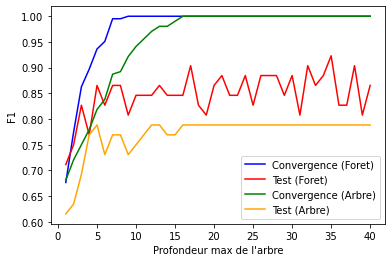

In [28]:
f1_train_pm_foret = []
f1_test_pm_foret = []
for max_prof in MAX_PROF_lst:
    classifieur = RandomForestClassifier(n_estimators=40, max_depth=max_prof)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_pm_foret.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_pm_foret.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(MAX_PROF_lst, f1_train_pm_foret, color="blue", label="Convergence (Foret)")
plt.plot(MAX_PROF_lst, f1_test_pm_foret, color="red", label="Test (Foret)")
plt.plot(MAX_PROF_lst, f1_train_pm, color="green", label="Convergence (Arbre)")
plt.plot(MAX_PROF_lst, f1_test_pm, color="orange", label="Test (Arbre)")
plt.ylabel("F1")
plt.xlabel("Profondeur max de l'arbre")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

#### II.2.3. Observations minimales dans les feuilles

Pour chaque nombre minimale des observations dans les feuilles, on entraîne un forêt et on mesure sa convergence et sa performance en terme du score F1. On compare les résultats avec les arbres équivalents (avec le même nombre des observations minimales)

**TODO : Analyser les résultats**
- Comparer la performance (convergence et généralisation) des arbres et des forêts en terme du noombre des observations dans les feuilles
- Justifier 

**Réponse**
- On remarque que la convergence diminue pour les arbres de décision et pour les forets aléatoires lorsque le nombre de feuilles minimales augmente mais il diminue de maniére plus considérable pour les forets aléatoires, pour ce qui est de la généralisation globalement on remarque que les forets aléatoires généralise mieux que les arbres de décision (une valeure du f1 score plus élevée).
- Justification : Au niveau de l'entrainement plus le nombre minimal d'observation par feuille augmente moins on aura de feuilles homogénes par ailleurs le f1 score des forets aléatoires diminue de maniére plus conséquente que celui des arbres car la forets est un enssemble d'arbres dont la construction varie beaucoup lorsque le nombre minimal d'observations par feuilles augmente donc on a plus de chance d'avoir des résultats faux lors de l'entrainement. Cependant cette grande divérsité des arbres dans les forets aléatoires permet une meilleure généralisation sur les données de test que celle obtenu avec l'arbre de décision.

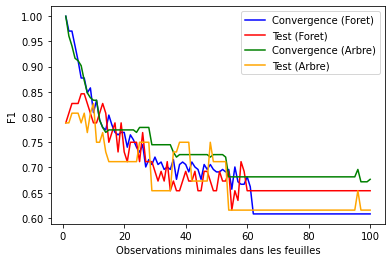

In [29]:
f1_train_mf_foret = []
f1_test_mf_foret = []
for min_feuille in MIN_FEUILLE_lst:
    classifieur = RandomForestClassifier(n_estimators=40, min_samples_leaf=min_feuille)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_mf_foret.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_mf_foret.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(MIN_FEUILLE_lst, f1_train_mf_foret, color="blue", label="Convergence (Foret)")
plt.plot(MIN_FEUILLE_lst, f1_test_mf_foret, color="red", label="Test (Foret)")
plt.plot(MIN_FEUILLE_lst, f1_train_mf, color="green", label="Convergence (Arbre)")
plt.plot(MIN_FEUILLE_lst, f1_test_mf, color="orange", label="Test (Arbre)")
plt.ylabel("F1")
plt.xlabel("Observations minimales dans les feuilles")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

#### II.2.4. Taille d'un Bootstrap

Ici, on définit un pourcentage de la taille des Bootstrap par rapport la taille initiale du dataset. Pour chaque pourcentage, on entraîne un forêt et on test sa performance (convergence et généralisation) en utilisant la mesure F1.

**TODO : Analyser les résultats**
- Que remarquez-vous ?
- Quelle est la raison pour laquelle la performance n'augmente pas d'une manière lisse ?

**Réponse**
- On remarque que le f1 score des données d'entrainement croit quand la taille du bootstrap par contre pour ce qui est des données de test le f1 score croit plus lentement et reste toujours instable, il varie de maniére fréquente dans un intervalle (entre deux valeurs)
- La performance n'augmente pas de manière lisse car les arbres de la foret s'entraine sur des échantillons de données différentes (bootstrap) par conséquent nous obtenons des arbres assez différents ce qui fit que les prédictions obtenus au niveau de chaque arbres  pour chaque donnée de test ont plus de chances d'etre différentes, ceci engendre une certaine instabilité pour le vote par majorité lors de la selection d'une prédiction c'est ainsi qu'on explique la variabilité et l'instabilité du f1 score pour les données de test. Mais bien que la taille du bootstrap augmante on remarque toujours cette instabilité du f1 score. Cependant lorsque la taille du bootstrap augmente le f1 score varie dans un intervalle de longueur plus petite mais entre deux valeurs de f1 score plus grandes qu'avec des petits bootstrap et ceci revient aux propriétés de notre dataset qui posséde une certaine variabilité des données et à la foret aléatoire en elle meme qui est composé de différents arbres.

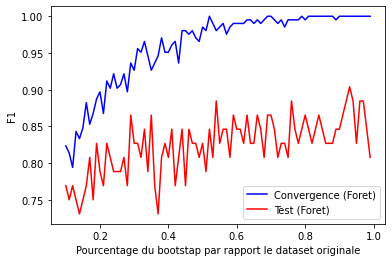

In [34]:
POUR_OBS_lst = np.arange(0.1, 1, 0.01)

f1_train_ech = []
f1_test_ech = []
for pour_obs in POUR_OBS_lst:
    classifieur = RandomForestClassifier(n_estimators=40, max_samples=pour_obs)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_ech.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_ech.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(POUR_OBS_lst, f1_train_ech, color="blue", label="Convergence (Foret)")
plt.plot(POUR_OBS_lst, f1_test_ech, color="red", label="Test (Foret)")
plt.ylabel("F1")
plt.xlabel("Pourcentage du bootstap par rapport le dataset originale")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()